# Example Layer Analysis
The goal of this notebook is to demonstrate how to use the `cortical-layers` package.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os

from caveclient import CAVEclient

from cortical_layers.LayerPredictor import BoundaryPredictor, LayerPrediction, LayerClassifier

# Predict the layer of some points
#### Get some inhibitory cell somas in a desired region--we're going to classify these cells by layer

In [3]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)
resolution = np.array([4., 4., 40.])  # nm per voxel
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v2")
auto_cells["pt_position_nm"] = [np.array(loc) * resolution for loc in auto_cells.pt_position.values]

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
bbox /= resolution
def in_bbox(p, bbox):
    """returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

inh_cells = auto_cells[auto_cells.pt_position.apply(in_bbox, args=[bbox])].query("cell_type == 'inhibitory'").copy()
inh_locs_nm = np.stack(inh_cells.pt_position_nm.values)

### Classify!
**All you need in order to classify the layer of some points is the name of the aligned volume or the path to a jsonified LayerPrediction object**

In [55]:
c = LayerClassifier(data="minnie65_phase3")
# Alternatively, specify the path to a specific LayerPrediction
# c = LayerClassifier(data=os.path.join(cache_dir, f"smooth_{name}_prediction.json"))

inh_cells["layer"] = c.predict(inh_locs_nm)

In [5]:
inh_cells

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,pt_position_nm,layer
21924,255208,t,aibs_coarse_inhibitory,inhibitory,88176641599308314,864691135915450982,"[170240, 95424, 22188]","[680960.0, 381696.0, 887520.0]",L1
21925,255129,t,aibs_coarse_inhibitory,inhibitory,89021959681198257,864691136143786292,"[176480, 101824, 20540]","[705920.0, 407296.0, 821600.0]",L23
21926,255120,t,aibs_coarse_inhibitory,inhibitory,88458185094541797,864691135614313931,"[172368, 95616, 20987]","[689472.0, 382464.0, 839480.0]",L1
21927,255218,t,aibs_coarse_inhibitory,inhibitory,88950697785090494,864691135491561567,"[176016, 95024, 22051]","[704064.0, 380096.0, 882040.0]",L1
21929,255137,t,aibs_coarse_inhibitory,inhibitory,89513991134704374,864691136521843345,"[179792, 97680, 20633]","[719168.0, 390720.0, 825320.0]",L1
...,...,...,...,...,...,...,...,...,...
80497,291116,t,aibs_coarse_inhibitory,inhibitory,90289765240834294,864691136390657919,"[185856, 110288, 20415]","[743424.0, 441152.0, 816600.0]",L23
80944,302902,t,aibs_coarse_inhibitory,inhibitory,91358078225916337,864691135082008055,"[193104, 205568, 20188]","[772416.0, 822272.0, 807520.0]",L5
80945,269475,t,aibs_coarse_inhibitory,inhibitory,88263571737698095,864691135568106476,"[170720, 218480, 22469]","[682880.0, 873920.0, 898760.0]",L6
80948,308834,t,aibs_coarse_inhibitory,inhibitory,90448507232048468,864691136005061066,"[186704, 244768, 20391]","[746816.0, 979072.0, 815640.0]",L6


#### More detailed information about the layer boundary predictions can be found in `c.pred`

In [6]:
c.pred?

Type:           LayerPrediction
String form:    <cortical_layers.LayerPredictor.LayerPrediction object at 0x00000221AE421FD0>
File:           c:\users\atmal\cortical-layers\cortical_layers\layerpredictor.py
Docstring:     
stores the prediction of layer boundaries (`bounds` in mm), including the columns for which predictions were made,
the values of the prediction, and the shape of the grid over which the predictions were made
Init docstring:
:param cols_nm: array of shape (n, 2, 3) of the bounding boxs of the columns for which the
                predictions were made, in nanometers
:param ngridpts: tuple of length 2. Grid shape of the columns. n = ngridpts[0] * ngridpts[1]
:param bounds: np.array of shape (n, len(layer_labels) - 1). The depths of the layer boundaries for each column (`cols_nm`) in mm.
                These are the predictions.
:param col_center_xs, col_center_zs: np.array of shape (ngridpts[0],) for x, or (ngridpts[1],) for z
                the center positions, in 

Since the columns (`c.pred.cols_nm`) and the resulting layer boundaries (`c.pred.bounds`) snake through the dataset in 2D, `c.pred.cols_nm` and `c.pred.bounds` follow that snaking traversal in their first dimension. To reshape them into to 2D spatial arrays, call `LayerPrediction.to_spatial_array(snaking_arr, ngridpts)`. For example

In [7]:
spatial_bounds = LayerPrediction.to_spatial_array(c.pred.bounds, c.pred.ngridpts)
print("shape of original snaking array:", c.pred.bounds.shape)
print("new shape:", spatial_bounds.shape)

shape of original snaking array: (512, 5)
new shape: (32, 16, 5)


### Now we can plot the layer bounds along with our inhibitory cells

Text(0.5, 0, 'z (microns)')

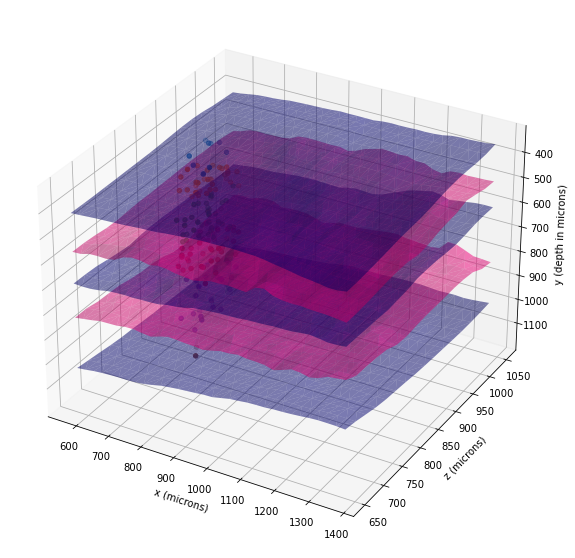

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
centers = c.pred.cols_nm.mean(axis=1) / 1_000

# surfaces
for j in range(5):
    ax.plot_trisurf(centers[:, 0], centers[:, 2], c.pred.bounds[:, j] * 1_000, color=(j % 2, 0, 0.5, 0.5))

# classified points
for layer in np.unique(inh_cells["layer"]):
    idxs = inh_cells["layer"] == layer
    ax.scatter(inh_locs_nm[idxs, 0] / 1_000, inh_locs_nm[idxs, 2] / 1_000, inh_locs_nm[idxs, 1] / 1_000, s=20)
    
ax.invert_zaxis()
ax.set_zlabel("y (depth in microns)")
ax.set_xlabel("x (microns)")
ax.set_ylabel("z (microns)")

### Create layer meshes compatible with neuroglancer

In [10]:
import matplotlib as mpl
from neuroglancer_scripts.mesh import save_mesh_as_precomputed

In [92]:
centers = c.pred.cols_nm.mean(axis=1)
tri = mpl.tri.Triangulation(centers[:, 0], centers[:, 2])

for i in range(5):
    v1_verts = np.array([tri.x, c.pred.bounds[:, i] * 1_000_000, tri.y], dtype=np.float32).T
    v1_faces = tri.triangles.astype(np.uint32)

    if not os.path.isdir('layermeshes'):
        os.makedirs('layermeshes')
    with open(f'layermeshes/{i}','wb') as fp:
        save_mesh_as_precomputed(fp, v1_verts, v1_faces)
with open(f'layermeshes/0:0','w') as fp:  # warning: 0:0 is not a valid filename in windows
    d = {'fragments':[str(i)]}
    fp.write(json.dumps(d))
        

## Get the spatial distribution of cell populations by layer

In [11]:
nuc_neuron = client.materialize.query_table("nucleus_neuron_svm")

### Pick a neuron type to look at

In [12]:
# one of "all" (all neurons from soma table), "neuron" (from nuc_neuron svm), "not-neuron" "exc", "inh", "BC", "BPC", "MC", "NGC", "5P_IT", "5P_PT", "5P_NP"
query_type = "not-neuron" 
if query_type == "all":
    query_type_cells = auto_cells
elif query_type == "neuron":
    query_type_cells = nuc_neuron[nuc_neuron.cell_type == "neuron"]
elif query_type == "not-neuron":
    query_type_cells = nuc_neuron[nuc_neuron.cell_type == "not-neuron"]
elif query_type  == "exc":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_excitatory'")
elif query_type  == "inh":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_inhibitory'")
elif query_type in ["BC", "BPC", "NGC", "MC", "5P_IT", "5P_PT", "5P_NP"]:
    query_type_cells = auto_cells.query(f"cell_type == '{query_type}'")
else:
    raise ValueError("""invalid query_type. must be one of 
                        'all', 'not-neuron', neuron', exc', 'inh', 'BC', 'BPC', 'MC', 'NGC', '5P_IT', '5P_PT', '5P_NP'""")

In [13]:
num_cells = dict()

In [14]:
def in_bbox(p, bbox):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

In [18]:
num_cells[query_type] = []

cell_locs = query_type_cells.pt_position.values
cell_locs_nm = np.array([np.array(loc) * resolution for loc in cell_locs])
c = LayerClassifier(data="minnie65_phase3")
query_type_cells["layer"] = c.predict(cell_locs_nm)

for i, col_nm in enumerate(c.pred.cols_nm):
    ncells = []
    col_cells = query_type_cells[query_type_cells.pt_position.apply(in_bbox, args=[col_nm / resolution])]
    for j, layer_name in enumerate(c.pred.layer_labels):
        ncells.append(sum(col_cells.layer == layer_name))
    num_cells[query_type].append(ncells)
    
num_cells[query_type] = np.array(num_cells[query_type])

c:\Users\ATMal\cortical-layers\cortical_layers\LayerPredictor.py:808: UserWarning: Some points are more than 50 microns laterally from the region where the predictions were made.
                They will be mapped to the nearest known point.
  They will be mapped to the nearest known point."""
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
cumul_num_cells = dict()
for t in num_cells:
    counts = np.array(num_cells[t])
    cumul = np.empty(counts.shape)
    cumul[:, 0] = counts[:, 0]
    for i in range(1, 6):
        cumul[:, i]  = cumul[:, i-1] + counts[:, i]
    cumul_num_cells[t] = cumul

In [83]:
centers = np.array(c.pred.cols_nm).mean(axis=1) / 1000
spatial_num_cells = dict()
for type_ in num_cells:
    spatial_num_cells[type_] = LayerPrediction.to_spatial_array(num_cells[type_], c.pred.ngridpts)

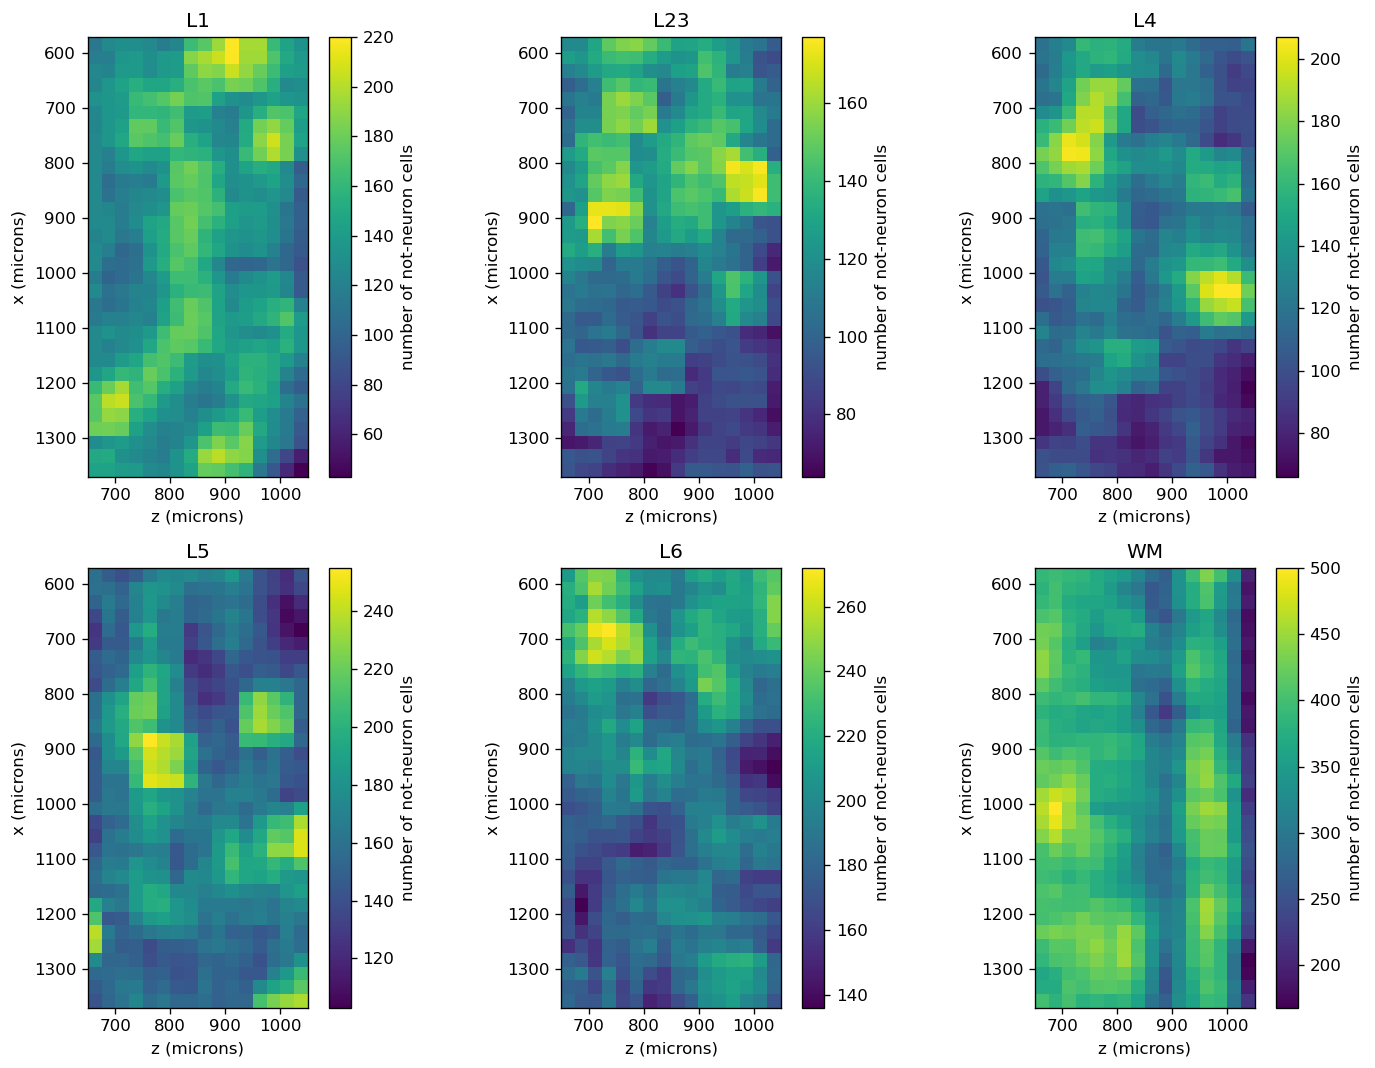

In [90]:
%matplotlib inline
# norm = mpl.colors.Normalize(0, max(map(np.max, num_cells.values())))
fig, axes = plt.subplots(2, 3, figsize=(12, 9), dpi=120)
axs = axes.flatten()
for i in range(6):
    im = axs[i].imshow(spatial_num_cells[query_type][:, :, i], extent=[c.pred.col_center_zs[0], c.pred.col_center_zs[-1], c.pred.col_center_xs[-1], c.pred.col_center_xs[0]])
    axs[i].set_title(LayerClassifier.LAYER_NAMES[i])
    plt.colorbar(im, ax=axs[i], label=f"number of {query_type} cells")
    axs[i].set_xlabel("z (microns)")
    axs[i].set_ylabel("x (microns)")
plt.tight_layout()

In [91]:
fig.savefig(f"laminarPopulationCountHeatmaps_{query_type}.svg")

### And the laminar distribution of cells across space

<IPython.core.display.Javascript object>


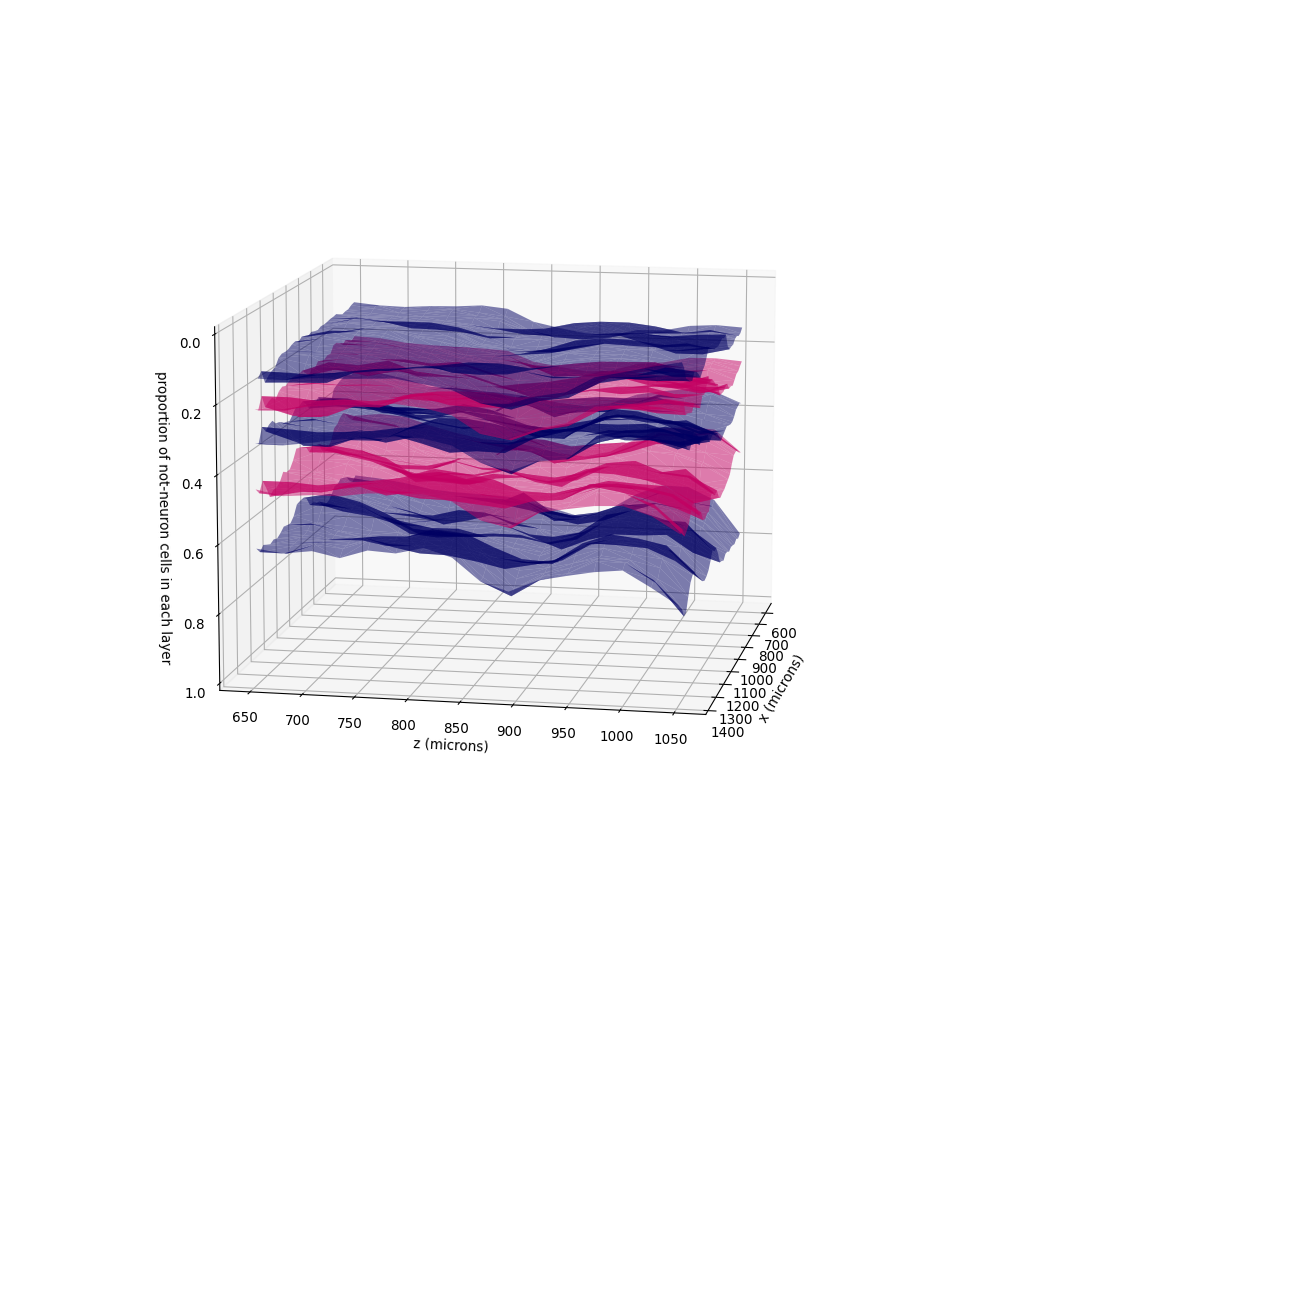

(1.0, 0.0)

In [101]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
for j in range(5):
    ax.plot_trisurf(centers[:, 0], centers[:, 2], cumul_num_cells[query_type][:, j] / cumul_num_cells[query_type][:, -1], color=(j % 2, 0, 0.5, 0.5))
ax.invert_zaxis()
ax.set_zlabel(f"proportion of {query_type} cells in each layer")
ax.set_xlabel("x (microns)")
ax.set_ylabel("z (microns)")
ax.set_zlim([1, 0])

In [80]:
fig.savefig(f"laminarPopulationProportions_{query_type}.svg")

In [97]:
# make sure you're not losing any data by reading or writing num_cells
num_cells.keys(), cumul_num_cells.keys()

(dict_keys(['inh', '5P_IT', '5P_PT', '5P_NP', 'exc', 'BC', 'MC', 'BPC', 'NGC', 'all', 'not-neuron']),
 dict_keys(['inh', '5P_IT', '5P_PT', '5P_NP', 'exc', 'BC', 'MC', 'BPC', 'NGC', 'all', 'not-neuron']))

In [93]:
# # load results
# def to_arr_dict(d):
#     return {k: np.asarray(d[k]) for k in d}
    
# with open("num_cells.json") as f:
#     num_cells_str = f.read()
# num_cells = to_arr_dict(json.loads(num_cells_str))
    
# with open("cumul_num_cells.json") as f:
#     cumul_num_cells_str = f.read()
# cumul_num_cells = to_arr_dict(json.loads(cumul_num_cells_str))

In [120]:
# # save results
# cumul_num_cells = to_list_dict(cumul_num_cells)
# num_cells = to_list_dict(num_cells)
# with open("num_cells.json", "w") as f:
#     f.write(json.dumps(num_cells))
# with open("cumul_num_cells.json", "w") as f:
#     f.write(json.dumps(cumul_num_cells))

# LayerPredictor on the entire minnie65 dataset

This section of the notebook shows exactly how the layer borders for the minnie65 dataset. There were, of course, many phases of iteration, but the final techniques and settings to produce the results are shown. The boundary predictor looks for the borders between L1, L2/3, L4, L5, L6, and WM. The L1-L2/3 border is determined by an excitatory soma density threshold, and the L6-WM border is determined by an excitatory soma density threshold. 

The remaining layer boundaries (the difficult ones) are determined by a Hidden Markov Model (HMM), where the emissions (observables/features) were soma density, mean soma volume, and standard deviation of soma volume, for excitatoy cells at each depth. Inhibitory cells are excluded. The features of a typical 100x100 micron column will look like this:

<img src='features_by_depth.png' width="400" height="400">

The HMM attempts to define the layers such that each layer is as homogenous as possible in terms of the 3 features. This analysis is done on 512 overlapping 100x100 micron columns in a 32x16 grid, in a 900x500 micron region that contains mostly well-imaged areas (with the exception of some very high z values). `LayerClassifier` predictions about points lying outside this 900x500 region are made by mapping them to the nearest part of the region. Each HMM is initialized using the layer boundaries of an adjacent column, traversing in a snaking path through the dataset. The first column is initialized with the default bounds [0.400516, 0.555516, 0.700516, 0.830516, 1.010516] mm.

The resulting layer borders from each column are then reviewed manually (by looking at the 512 output plots of `BoundaryPredictor`) and if any borders need correction (in this case 11 of them needed correction by about 30 microns), they are manually updated. The results are finally smoothed by convolving with a 3x3 gaussian kernel with $2 \sigma^2 = 0.8 \text{ idxs}^2$ for each layer boundary.

You need a pickled soma table with a `soma_volume` column to run this analysis.

In [55]:
# conservative bbox only containing well-segmented areas
seg_low_um = np.array([130_000, 50_000, 15_000]) * resolution / 1_000
seg_up_um = np.array([355_000, 323_500, 27_500]) * resolution / 1_000
name = "minnie65_full"
cache_dir = r".\cortical_layers"

p = BoundaryPredictor(features=("soma_volume",), num_PCA=None, use_depth=False, use_soma_vol_std=True, resolution=resolution, 
                      save_figs=True, verbose=True, 
                      name=name, cache_dir=cache_dir, l1_2_thresh=120_000, l6_WM_thresh=50_000, 
                      soma_table_path=os.path.join(cache_dir, "Minnie_soma_nuc_feature_model_83_1.pkl"))

In [56]:
%matplotlib inline
try:
    pred = LayerPrediction.load(os.path.join(cache_dir, f"{name}_prediction.json"))
except IOError:
    # THIS DOES THE PREDICTION. It may take an hour on a laptop.
    pred = p.predict(np.array([seg_low_um, seg_up_um]), col_size=(100, 100), ngridpts=(32, 16))

In [88]:
# manual modifications based on proofreading all 512 plots
pred.bounds[69][3] = 0.85
pred.bounds[90][3] = 0.82
pred.bounds[91][3] = 0.82
pred.bounds[101][3] = 0.85
pred.bounds[312][3] = 0.81
pred.bounds[442][3] = 0.81

pred.bounds[161:165, 1] = 0.54
pred.bounds[500][1] = 0.5

In [89]:
# smooth out the results and save a copy
smooth_pred = pred.deepcopy()
smooth_pred.name = "smooth_" + smooth_pred.name
p.smooth_bounds(smooth_pred, smoothness=0.8)
smooth_pred.save()  # <- This is the final result!

# Generating the boundary between layer 6a and 6b

This follows the same procedure as above within layer 6. It only uses excitatory soma density and volume to determine the layer borders, and mandates that the border is placed more than half way between the layer 5-6 border and the layer 6-WM border.

In [3]:
from cortical_layers.SublayerPredictor import SubBoundaryPredictor

In [4]:
resolution = np.array([4., 4., 40.])
# conservative bbox only containing well-segmented areas
seg_low_um = np.array([130_000, 50_000, 15_000]) * resolution / 1_000
seg_up_um = np.array([355_000, 323_500, 27_500]) * resolution / 1_000
# name = "sub6_soma_vol_and_density_second_half_only_200micron"
name = "sub6_soma_vol_and_density_second_half_only_test"
cache_dir = r".\cortical_layers"
p = SubBoundaryPredictor(features=("soma_volume",),
                            num_PCA=None, use_depth=False, use_exc_soma_density=True, use_soma_vol_std=False,
                            resolution=resolution, save_figs=True, verbose=True, cache_dir=".\\" + name,
                            name=name, soma_table_path=os.path.join(cache_dir, "Minnie_soma_nuc_feature_model_83_1.pkl"))
c = LayerClassifier(data=f"minnie65_phase3")

In [5]:
%matplotlib inline
try:
    pred = LayerPrediction.load(os.path.join(name, f"{name}_prediction.json"))
except IOError:
    # THIS DOES THE PREDICTION. It may take an hour on a laptop.
    pred = p.predict(c.pred, layer="L6", num_sublayers=2, min_depth=0.5)

In [6]:
if name == "sub6_soma_vol_and_density_second_half_only_test":
    # manual modifications based on proof   reading all 512 plots of sub6_soma_vol_and_density_second_half_only_test
    pred.bounds[8][4] = 1.02
    pred.bounds[19][4] = 1.02
    pred.bounds[25][4] = 1.02
    pred.bounds[27][4] = 1.02
    pred.bounds[41][4] = 1.02
    pred.bounds[45][4] = 1.02
    pred.bounds[49][4] = 1.02
    pred.bounds[53][4] = 1.02
    pred.bounds[55][4] = 1.02
    pred.bounds[74][4] = 1.02
    pred.bounds[86][4] = 1.02
    pred.bounds[381][4] = 0.93
    pred.bounds[413][4] = 0.91

if name == "sub6_soma_vol_and_density_second_half_only_200micron":
    # manual modifications based on proofreading all 512 plots of sub6_soma_vol_and_density_second_half_only_200micron
    pred.bounds[9][4] = 1.02
    pred.bounds[11][4] = 1.02
    pred.bounds[14][4] = 1.02
    pred.bounds[16][4] = 1.02
    pred.bounds[19][4] = 1.02
    pred.bounds[21][4] = 1.02
    pred.bounds[45][4] = 1.02
    pred.bounds[47][4] = 1.02
    pred.bounds[77][4] = 1.02
    pred.bounds[414:418, 4] = 0.93
    pred.bounds[478][4] = 0.92
    pred.bounds[446:451, 4] = 0.915

In [7]:
c = LayerClassifier(data="minnie65_phase3-sub6")
c.pred.layer_labels

['L1', 'L23', 'L4', 'L5', 'L6a', 'L6b', 'WM']

In [8]:
# smooth out the results and save a copy
smooth_pred = pred.deepcopy()
smooth_pred.name = "smooth_" + smooth_pred.name
p.smooth_bounds(smooth_pred, smoothness=0.8)
smooth_pred.cache_dir = ".\\" + name
smooth_pred.save()  # <- This is the final result!

### make csv of points on 6a/b border mesh in this format

In [22]:
# ### CSV example ###
# Coordinate 1,Coordinate 2,Ellipsoid Dimensions,Tags,Description,Segment IDs,Parent ID,Type,ID
# "(325184, 116528, 20620)",,,,,553407,,Point,
# "(174944, 137648, 21113)",,,,,258307,,Point,
# "(286992, 125056, 23883)",,,,,487512,,Point,
# "(348352, 119296, 19182)",,,,,610396,,Point,

idx = 4
with open(f"mesh_points{name}_{c.pred.layer_labels[idx]}-{c.pred.layer_labels[idx + 1]}.csv", "w") as f:
    text = "Coordinate 1,Coordinate 2,Ellipsoid Dimensions,Tags,Description,Segment IDs,Parent ID,Type,ID\n"
    mids = []
    for col_nm, bounds_mm in zip(smooth_pred.cols_nm, smooth_pred.bounds):
        col_mid_nm = (col_nm[1] + col_nm[0]) / 2
        mids.append(col_mid_nm)
        x_vx = int(col_mid_nm[0] / 4)
        y_vx = int(bounds_mm[idx] * 1_000_000 / 4)
        z_vx = int(col_mid_nm[2] / 40)
        text += f"\"({x_vx}, {y_vx}, {z_vx})\",,,,,,,Point,\n"
    text = text[:-1]  # remove last newline
    f.write(text)

## find spatial density of synapses within each layer

In [3]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)
resolution = np.array([4., 4., 40.])  # nm per voxel
syns = client.materialize.query_table("synapses_pni_2", limit=10, split_positions=True)
syns

,id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,post_pt_supervoxel_id,post_pt_root_id,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size
0,106675816,t,142854,244590,18572,84396795031127211,864691136041487043,142946,244642,18573,84467163775312026,864691135589913867,142890,244657,18573,508
1,58059862,t,120492,136916,15377,81356507538572374,864691134686377805,120494,136946,15368,81356507538560968,864691136618474893,120527,136988,15374,9516
2,334196813,t,281168,190270,25546,103459441311512485,864691136915328110,281088,190226,25551,103389072567345977,864691135467566732,281134,190266,25552,2500
3,107325722,t,150414,117194,16963,85435214842683790,864691136352199039,150450,117248,16960,85435214842672897,864691136175044870,150430,117218,16963,12444
4,504197277,t,400116,134684,23797,119777499336109711,864691135369918348,400004,134706,23786,119777499336092788,864691135559552342,400054,134646,23794,5132
5,221337505,t,213692,105712,22587,94159428030403803,864691135654208866,213698,105780,22591,94159428030414626,864691135604551235,213734,105764,22595,13412
6,418100595,t,331350,99642,18183,110343413953801999,864691135606272302,331362,99584,18180,110343413953801875,864691135476139688,331362,99632,18179,5132
7,404648211,t,326574,117304,19642,109642063175463918,864691135698389000,326574,117426,19637,109642063175459395,864691134240471483,326635,117344,19638,6916
8,328132365,t,276746,235448,15477,102832168652386172,864691135599582669,276818,235544,15475,102832168652387224,864691136690850140,276784,235508,15476,2984
9,79055260,t,120172,144160,18228,81287101202983385,864691135376329790,120082,144246,18224,81287101202973335,864691136989989525,120130,144257,18223,7628


In [53]:
data_bounds_vx = [[52_770, 60_616, 14_850], [437_618, 322_718, 27_858]]
step = 5
width_um = 20
xwidth_vx = width_um * 1000 // 4
zwidth_vx = width_um * 1000 // 40
xlinspace = range(data_bounds_vx[0][0], data_bounds_vx[1][0], xwidth_vx)
zlinspace = range(data_bounds_vx[0][2], data_bounds_vx[1][2], zwidth_vx)
conservative_layers_vx =  [[90000,      93736 ],  # l1 top, l1 bottom  
                        [109090, 119464],  # l23 top, l23 bottom
                        [143690, 152896],  # l4 top, l4 bottom
                        [178807, 187132],  # l5
                        [219636, 234825]]  # l6
layer_names = ["L1", "L23", "L4", "L5", "L6"]
densities = np.zeros((len(conservative_layers_vx), len(xlinspace) - 1, len(zlinspace) - 1))
for i in range(len(conservative_layers_vx)):
    for x in range(0, len(xlinspace) - 1, step):
        for z in range(0, len(zlinspace) - 1, step):
            bb = [[xlinspace[x], conservative_layers_vx[i][0], zlinspace[z]], 
                  [xlinspace[x + 1], conservative_layers_vx[i][1], zlinspace[z + 1]]]
            syns = client.materialize.query_table("synapses_pni_2", filter_spatial_dict={"ctr_pt_position": bb}, split_positions=True)
            vol = (bb[1][0] - bb[0][0]) * (bb[1][1] - bb[0][1]) * (bb[1][2] - bb[0][2])
            print(i, x, z, len(syns) / vol)
            densities[i, x, z] = len(syns) / vol



0 0 0 0.0
0 0 5 0.0
0 0 10 0.0
0 0 15 0.0
0 0 20 0.0
0 0 25 0.0
0 5 0 0.0
0 5 5 0.0
0 5 10 0.0
0 5 15 0.0
0 5 20 0.0
0 5 25 0.0
0 10 0 0.0
0 10 5 0.0
0 10 10 8.565310492505353e-10
0 10 15 1.3029978586723768e-07
0 10 20 6.407922912205567e-07
0 10 25 1.1006423982869379e-07
0 15 0 0.0
0 15 5 3.2119914346895073e-10
0 15 10 7.644539614561027e-08
0 15 15 6.158458244111349e-07
0 15 20 6.489293361884368e-07
0 15 25 5.215203426124197e-07
0 20 0 0.0
0 20 5 1.80406852248394e-07
0 20 10 5.07066381156317e-07
0 20 15 7.421841541755888e-07
0 20 20 6.473233404710921e-07
0 20 25 5.300856531049251e-07
0 25 0 8.288008565310493e-07
0 25 5 1.4989293361884368e-08
0 25 10 3.9014989293361884e-07
0 25 15 7.880085653104925e-07
0 25 20 5.980728051391863e-07
0 25 25 6.140256959314775e-07
0 30 0 8.512847965738759e-07
0 30 5 7.699143468950749e-07
0 30 10 4.554603854389722e-07
0 30 15 7.113490364025696e-07
0 30 20 3.161670235546039e-07
0 30 25 5.619914346895075e-07
0 35 0 8.359743040685225e-07
0 35 5 8.3661670235546

In [ ]:
densities.shape

(5, 102, 34)

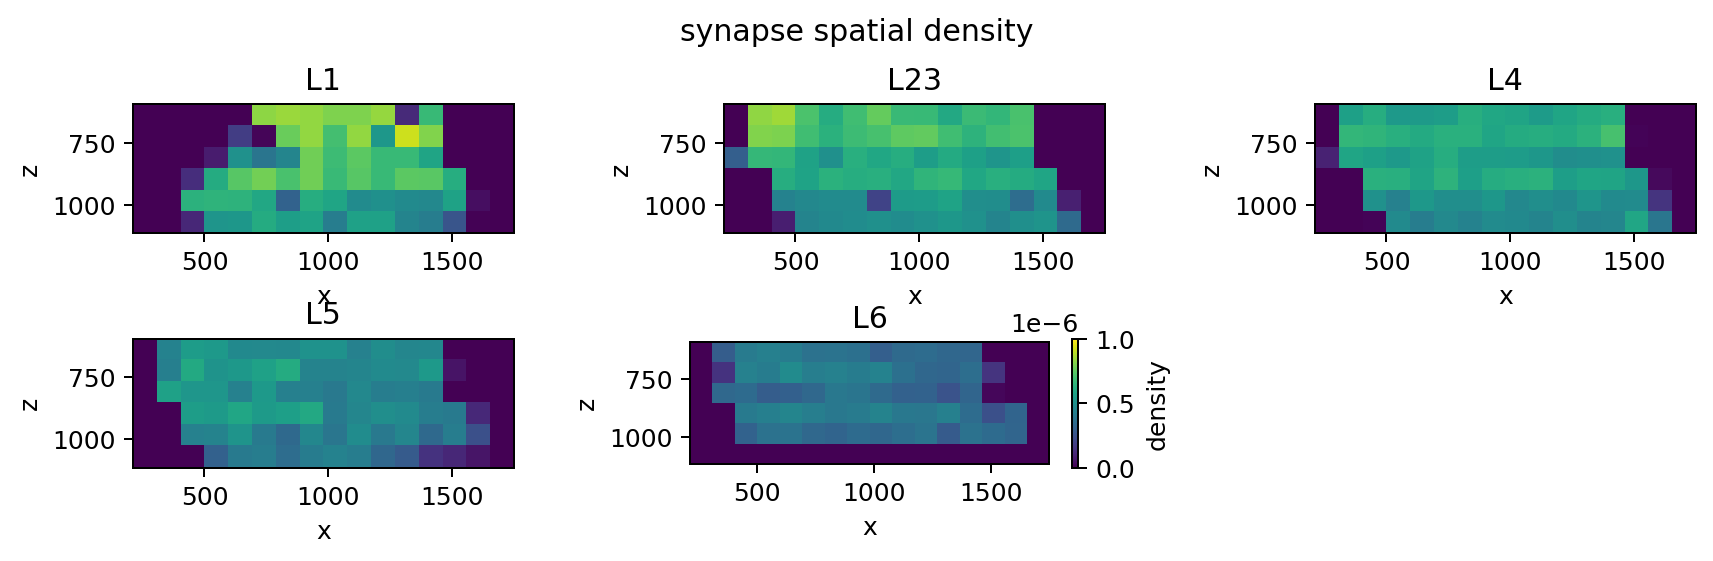

In [54]:
plt.figure(dpi=180, figsize=(10, 3))
plt.suptitle("synapse spatial density")
for i in range(len(densities)):
    plt.subplot(2, 3, i+1)
    plt.title(layer_names[i])
    plt.xlabel("x")
    plt.ylabel("z")
    plt.imshow(densities[i, ::step, ::step].T, vmin=0, vmax=1e-6, extent=[52_770 * 4 / 1000, 437_618 * 4 / 1000, 27_858 * 40 / 1000, 14_850 * 40 / 1000])
plt.colorbar(label="density")
plt.tight_layout()

## Test sensitivity to initial conditions

#### Results of testing sensitivity to initial conditions for the column offset +x from minnie col with x coordinate 243111 nm

When initialized using L3-L4 border = 0.54 (depth of L3-L4 border in minnie col), the result was 0.54, with a final log likelihood score of -328
    - This is even the case when use_depth = False, for which the final score was -350 (keep in mind this has one less covariate, which should increas the score)
    - 0.54, use_depth=False, features=tuple(), use_soma_vol_std=False resulted in 0.5, score was -60
    - 0.54, use_depth=False, features=("soma_volume",), use_soma_vol_std=False resulted in 0.5, score was -104


When initialized using L3-L4 border = 0.5, the result was 0.5, with a final log likelihood score of -305 (better)

## How to get the IDs of cells in a given column and layer

In [61]:
all_cells = client.materialize.query_table("nucleus_neuron_svm")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = all_cells[all_cells.pt_position.apply(in_bbox)].copy()

In [62]:
col_cells["pos_nm"] = [(np.array(loc) * resolution) for loc in col_cells.pt_position.values]

In [63]:
c = LayerClassifier(data=os.path.join(cache_dir, f"smooth_{name}_prediction.json"))
col_cells["layer"] = c.predict(np.stack(col_cells.pos_nm.values))

In [66]:
print(col_cells.query("layer == 'L1'").id.values.tolist())

[252336, 251777, 252426, 291126, 286254, 252124, 286743, 286724, 252148, 255185, 255164, 252409, 286603, 286673, 255133, 286423, 282999, 251716, 255120, 286604, 286990, 286999, 286456, 251407, 286637, 251779, 251755, 254978, 252183, 252436, 286706, 286913, 286643, 252062, 286611, 291108, 251862, 286267, 286266, 252227, 286921, 247993, 252356, 252043, 252380, 252114, 252430, 287049, 255122, 283054, 287083, 291206, 282951, 291180, 285745, 286700, 286554, 286334, 251843, 286247, 255132, 286645, 286729, 286988, 251822, 286710, 252346, 252116, 286467, 286742, 286258, 251787, 286914, 251784, 286460, 252174, 252381, 287134, 247873, 252002, 286325, 252109, 252157, 251798, 286666, 286987, 291219, 255137, 286296, 252164, 286621, 286601, 287077, 286301, 291118, 251753, 286329, 291182, 252242, 255218, 252232, 287036, 291201, 247981, 283043, 251780, 286625, 255152, 252145, 286656, 282972, 252146, 252076, 252359, 251817, 251143, 286297, 286264, 286638, 251770, 286316, 252130, 255123, 286549, 252014,